<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_binMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [13]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [14]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


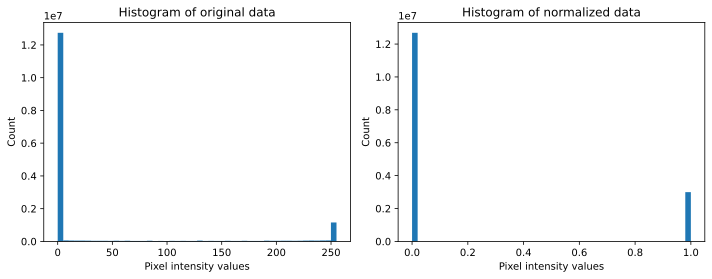

In [15]:
#normalize the data to a range of [0 1]
dataNorm=(data>0).astype(float)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Confirm that the data have limited values

In [16]:
print(np.unique(data))
print(' ')
print(np.unique(dataNorm))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

Create train/TEST GROUPS USING DataLoader

In [17]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [18]:
#check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTNet at 0x78bd30004720>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                 ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<

Create the DL model

In [19]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax(self.output(x),axis=1)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.NLLLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

In [20]:
#test the model with one batch
net,lossfun,optimizer=createTheMNISTNet()
X,y =next(iter(train_loader))
yHat = net(X)
print(torch.exp(yHat))
loss = lossfun(yHat,y)
print(loss)

tensor([[0.0922, 0.0927, 0.0846, 0.0883, 0.1143, 0.0960, 0.1250, 0.1169, 0.0980,
         0.0920],
        [0.0924, 0.0945, 0.0867, 0.0857, 0.1158, 0.0965, 0.1229, 0.1154, 0.0997,
         0.0904],
        [0.0919, 0.0931, 0.0863, 0.0862, 0.1156, 0.0955, 0.1248, 0.1160, 0.0997,
         0.0910],
        [0.0934, 0.0938, 0.0864, 0.0857, 0.1165, 0.0955, 0.1243, 0.1154, 0.0983,
         0.0905],
        [0.0917, 0.0927, 0.0844, 0.0891, 0.1141, 0.0941, 0.1265, 0.1162, 0.0986,
         0.0927],
        [0.0916, 0.0933, 0.0849, 0.0878, 0.1150, 0.0948, 0.1243, 0.1162, 0.1003,
         0.0918],
        [0.0927, 0.0928, 0.0850, 0.0879, 0.1157, 0.0956, 0.1248, 0.1155, 0.0986,
         0.0913],
        [0.0910, 0.0919, 0.0855, 0.0869, 0.1153, 0.0968, 0.1255, 0.1160, 0.0998,
         0.0916],
        [0.0916, 0.0929, 0.0848, 0.0873, 0.1160, 0.0971, 0.1259, 0.1148, 0.0988,
         0.0909],
        [0.0924, 0.0922, 0.0844, 0.0891, 0.1137, 0.0946, 0.1261, 0.1159, 0.0982,
         0.0934],
        [0

Create a function that trains the model

In [21]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=60
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

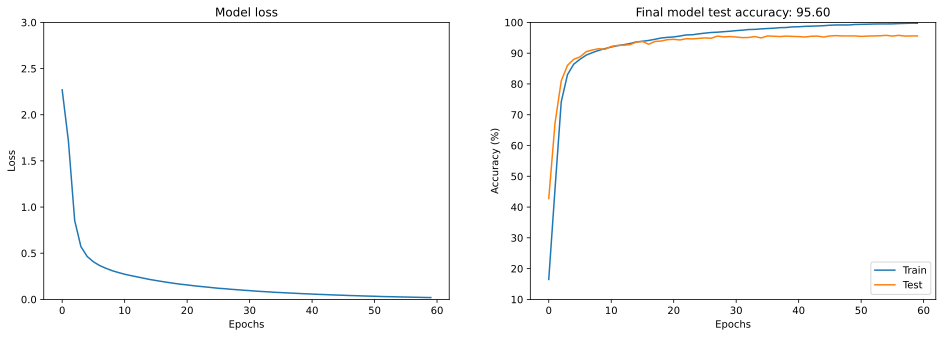

In [11]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

Inspect the results in more detail

In [22]:
X,y=next(iter(test_loader))
predictions=net(X).detach()
predictions

tensor([[-2.3778, -2.3604, -2.4562,  ..., -2.1564, -2.3077, -2.4023],
        [-2.3926, -2.3849, -2.4613,  ..., -2.1492, -2.3016, -2.3829],
        [-2.3888, -2.3807, -2.4637,  ..., -2.1586, -2.3011, -2.3770],
        ...,
        [-2.3917, -2.3844, -2.4634,  ..., -2.1553, -2.3130, -2.3836],
        [-2.3852, -2.3719, -2.4467,  ..., -2.1536, -2.3077, -2.3957],
        [-2.3876, -2.3990, -2.4680,  ..., -2.1459, -2.3081, -2.3869]])

<ipython-input-23-9d383132a6fc>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(range(10),np.exp(predictions[sample2show]))


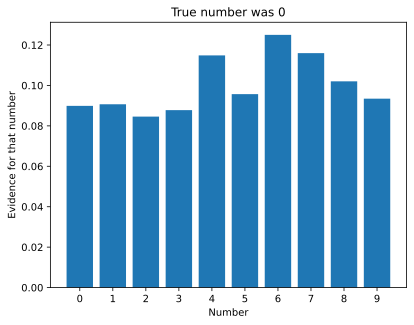

In [23]:
#evidence for all numbers from one sample
sample2show=120
plt.bar(range(10),np.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title("True number was %s"%y[sample2show].item())
plt.show()

[   0    1    2 ... 1996 1997 1998]


<ipython-input-24-605ba88b614e>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


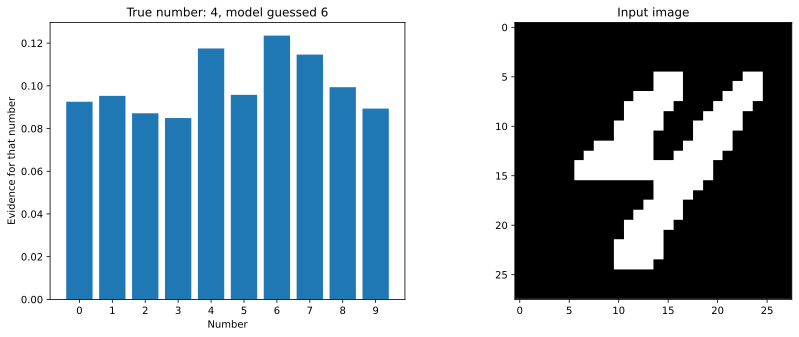

In [24]:
from typing import ChainMap
#find the errors
errors=np.where(torch.argmax(predictions,axis=1)!=y)[0]
print(errors)
#Evidence for all numbers from one sample
sample2show=10
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(),torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show],:],(28,28)),cmap='gray')
ax[1].imshow(X[errors[sample2show]].view(28,28),cmap='gray')
ax[1].set_title('Input image')
plt.show()